# Introducing Ensemble Learning and Random Forests

- Voting classifiers
- Stacking
- Bagging and patching
- Random forests and variations
- Boosting

## Voting Classifiers

We take the output of multiple classifiers and take a vote to make a final decision:

1. Hard voting: Aggregate prediction from each classifier. Class with most votes wins
2. Soft voting: Take average prediction probability across each classifier. Class with highest average probability wins. Gives more weight to more confident votes.

<img src="forest1.png" alt="SVM" style="width:450px;"/>

Scikit-Learn `VotingClassifier` class can help automate this process.

Following is adapted from Chapter 7 of Hands-On Machine Learning by Gurien.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [5]:
##Function for the decision boundaries:
######

#Colormap we'll use:

from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["red", "blue"]))

##Let's make a function to plot our decision surface:
######

def plot_contour(X, clf, ax):
    #Range for contour:
    x1 = np.min(X[:,0]); x2 = np.max(X[:,0])*1.025
    y1 = np.min(X[:,1]); y2 = np.max(X[:,1])*1.025

    if (x1 < 0):
        x1 = x1 * 1.025
    else:
        x1 = x1 * .975
        
    if (y1 < 0):
        y1 = y1 * 1.025
    else:
        y1 = y1 * .975
        
    #Points for contour
    X1, Y1 = np.meshgrid(np.linspace(x1, x2, 200),
                             np.linspace(y1, y2, 200))

    #Get as Nx2:
    XY_ravel = np.c_[X1.ravel(), Y1.ravel()]


    #Get the class:
    Z = clf.predict(XY_ravel)

    #Reshape back:
    Z = Z.reshape(X1.shape)


    #Plot:
    ax.contourf(X1, Y1, Z, 10, alpha=.5, cmap=my_cmap)

    ax.contour(X1, Y1, Z, 1, alpha=1, linewidths=1, colors='black')


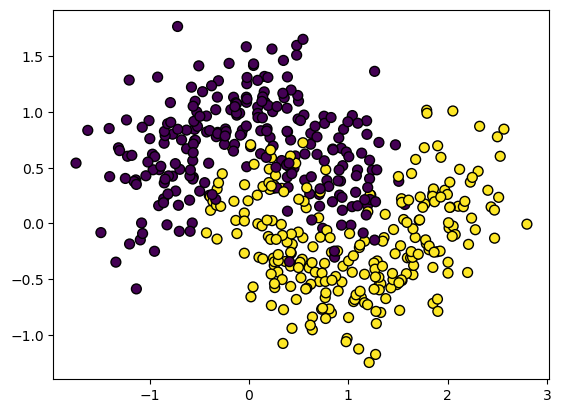

In [6]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Plot the Moons data real quick:
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='black', s=50);

In [8]:
## Make an ensemble of classifiers:
##############

#Use a Logistic Regression Classifier with Polynomial Features:
poly_lr_clf = make_pipeline(PolynomialFeatures(degree=3),
                            StandardScaler(),
                            LogisticRegression(C=10))

#Set up for soft voting:
####

voting_clf = VotingClassifier(voting='soft',
    estimators=[
        ('lr_poly', poly_lr_clf),
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier(n_neighbors=12)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))])

##Fit the classifier:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_poly',
                              Pipeline(steps=[('polynomialfeatures',
                                               PolynomialFeatures(degree=3)),
                                              ('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=10))])),
                             ('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier(n_neighbors=12)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
## Check the accuracy of the voting classifier:
voting_clf.score(X_test, y_test)

0.896

In [10]:
#Each individual classifier?
for name, clf in voting_clf.named_estimators_.items():
    print(name, ' = ', clf.score(X_test, y_test))

lr_poly  =  0.872
lr  =  0.864
knn  =  0.896
rf  =  0.896
svc  =  0.896


## Stacking

- We can also send the output of our predictors to a final predictor known as the "blender" or "meta-learner"
- Number of input features to blender = Number of predictors in first ensemble layer

<img src="forest5.png" alt="Forest" style="width:450px;"/>


In [11]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))],
    
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5  # Cross-validation folds
)

stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [12]:
#Ooh, does better!
stacking_clf.score(X_test, y_test)

0.912

## Bagging (and Patching)

- Train multiple predictors on random samples of the data
- Sample *with* replacement = *bagging* (from *bootstrap aggregating*)
- Sample *without* replacement = *patching*

Take average (regression) or mode (classification) of predictors for final prediction.

<img src="forest2.png" alt="Forest" style="width:475px;"/>

- Note that this parallelizes well, for both training and prediction

- Can do bagging (or patching) for a generic classifier using class `BaggingClassifier`
    - See https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
    
- Applied to Decision Trees:
        

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


#Bagging classifier:
#######

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=len(X_train),
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=375,
                  n_estimators=500, oob_score=True, random_state=42)

In [15]:
## Compare to a default Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
#Check the Out-of-bag score:
print(bag_clf.oob_score_)

#Compare to a cross-validation score on the single tree:
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(tree_clf, X_train, y_train,
                scoring="accuracy", cv=10))


0.896


0.8558321479374111

In [18]:
#Vs. performance on test data:
print(bag_clf.score(X_test, y_test))

print(tree_clf.score(X_test, y_test))

0.92
0.856


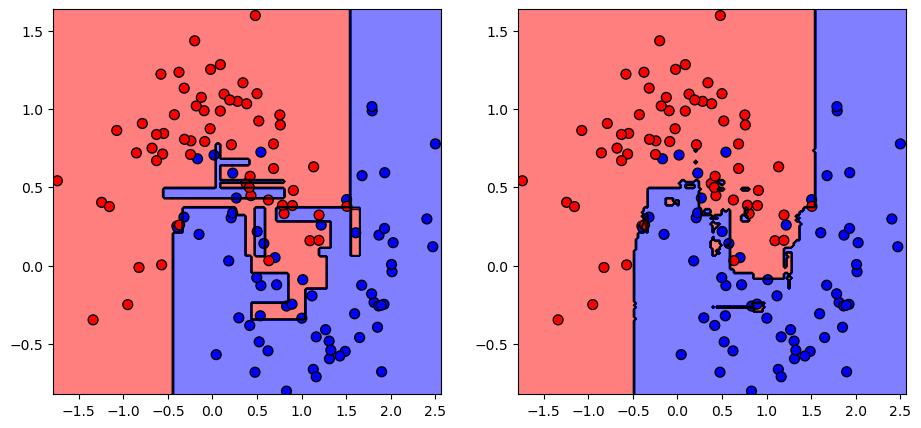

In [19]:
##Compare vanilla tree and bag of trees:
#########

fig1, ax1 = plt.subplots(1, 2, figsize=(11,5))

plot_contour(X_test, tree_clf, ax1[0])
ax1[0].scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

plot_contour(X_test, bag_clf, ax1[1])
ax1[1].scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

### Sample Features

- Can use `max_features` and `bootstrap_features` to control feature sampling

**Random Patches** = Sampling both observations and features

**Random Subspaces** = Sampling only features; use all observations

## Random Forests

- Random forests are constructed by bagging trees using all observations (i.e., bootstrap resampling of all instances)

- Plus, classically only $\sqrt{n}$ features are selected at each node

- Scikit-Learn uses all features by default for Regressor, 'sqrt' for Classifier:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
- Can make using `BaggingClassifier`:

In [20]:
#Random forest partly by hand:
forest_manual_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=len(X_train),
                            max_features = int(np.ceil(np.sqrt(2))),
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)

forest_manual_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=2,
                  max_samples=375, n_estimators=500, oob_score=True,
                  random_state=42)

In [21]:
forest_manual_clf.oob_score_

0.896

In [22]:
#Built-in RandomForest:
forest_clf = RandomForestClassifier(n_estimators=500,
                                    max_features='sqrt', oob_score=True, random_state=42)
forest_clf.fit(X_train, y_train)

forest_clf.oob_score_

0.904

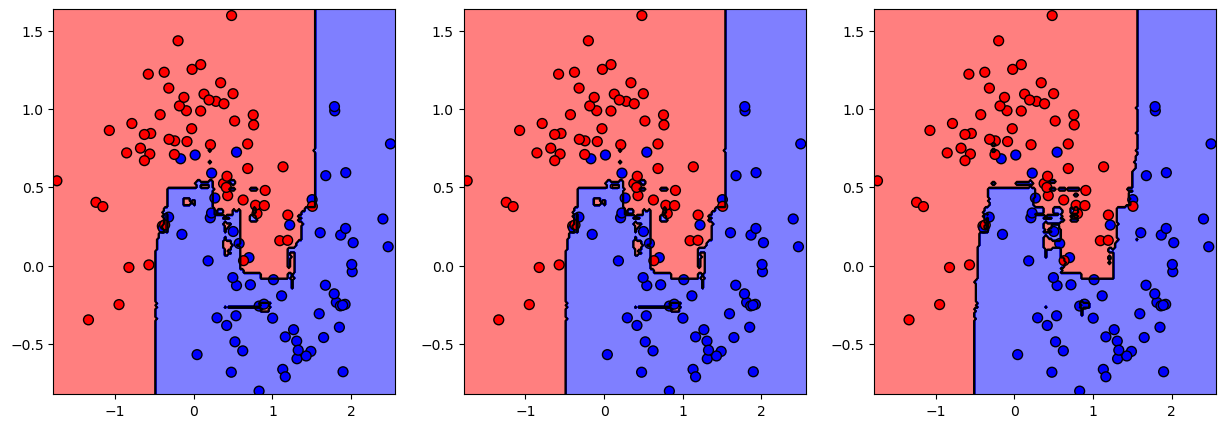

In [23]:
#Compare our earlier bagging classifier to the random forests proper
fig1, ax1 = plt.subplots(1, 3, figsize=(15,5))

plot_contour(X_test, bag_clf, ax1[0])
ax1[0].scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

plot_contour(X_test, forest_manual_clf, ax1[1])
ax1[1].scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

plot_contour(X_test, forest_clf, ax1[2])
ax1[2].scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

## Extra-Trees

- With an extra-tree, we randomly set the threshold for splitting
- Can be trained faster, performance generally similar to random forest

In [24]:
#Extra tree partly by hand:
extra_tree_clf = BaggingClassifier(DecisionTreeClassifier(splitter='random'),
                            n_estimators=500,
                            max_samples=len(X_train),
                            max_features = int(np.ceil(np.sqrt(2))),
                            bootstrap=False,
                            random_state=42)

extra_tree_clf.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(splitter='random'),
                  max_features=2, max_samples=375, n_estimators=500,
                  random_state=42)

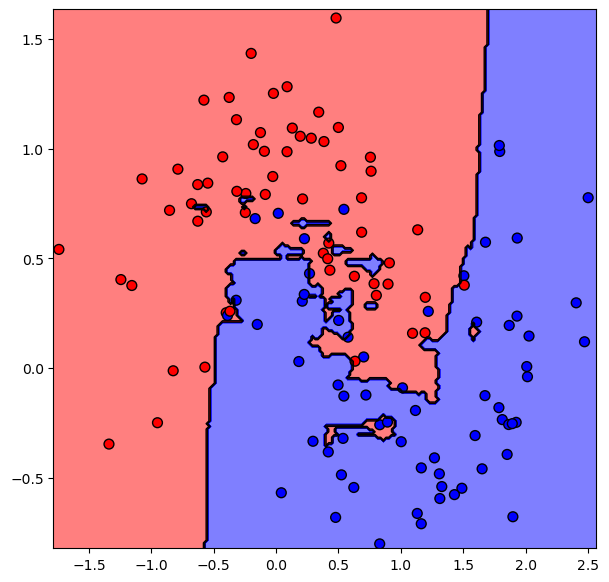

In [25]:
#And we get?
fig1, ax1 = plt.subplots(1, 1, figsize=(7,7))

plot_contour(X_test, extra_tree_clf, ax1)
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

## Feature Importance

- Can measure feature importance by how much tree nodes that use a feature reduce impurity, averaged across all trees


In [26]:
##Simply:
#####

forest_clf.feature_importances_

array([0.43798008, 0.56201992])

In [27]:
## On the iris data:
######

##Grab the data
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

X = iris.data
y = iris.target


In [28]:
#Remakeand fit our forest classifier
forest_clf = RandomForestClassifier()

forest_clf.fit(X, y)


RandomForestClassifier()

In [29]:
#Feature importances?
#####

for name, i in zip(iris.data.columns, forest_clf.feature_importances_):
    print(name, ': ', i)

sepal length (cm) :  0.11264418714431784
sepal width (cm) :  0.024050148419103527
petal length (cm) :  0.4117604523089482
petal width (cm) :  0.4515452121276304


### MNIST Numbers:

<img src="forest3.png" alt="SVM" style="width:425px;"/>

## Boosting

- Train predictors in sequence.
- Try to correct errors of predecessor
- Take ensemble average across predictors

Two major versions:

1. AdaBoost (from adaptive boosting)
2. Gradient Boosting

#### AdaBoost

- Increase relative weight of misclassified instances
- Take final weighted average of predictors: Weight based on accuracy of predictor on training set

<img src="forest4.png" alt="SVM" style="width:450px;"/>

In [30]:
### Example in sk-learn:
#########

from sklearn.ensemble import AdaBoostClassifier

#Base classifier that we'll boost:
#Decision "stump": tree with single decision node and two leaf nodes:
base_clf = DecisionTreeClassifier(max_depth=1)

#AdaBoost Classifier:
ada_clf = AdaBoostClassifier(base_clf,
                             n_estimators=100,
                             learning_rate=0.1,
                             random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=100, random_state=42)

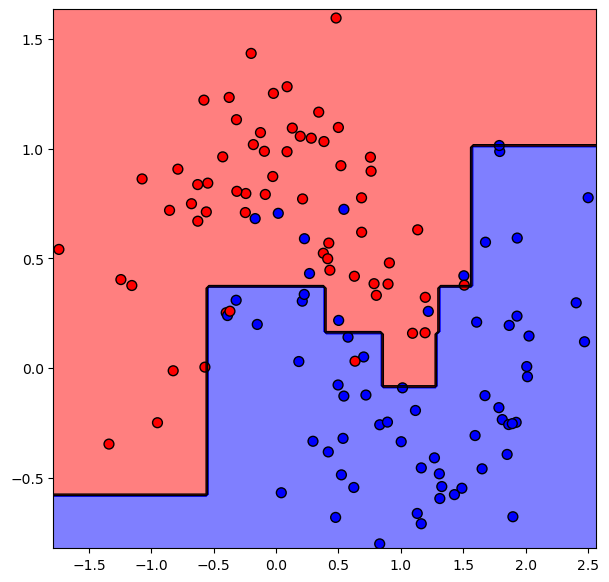

In [31]:
#Result??
fig1, ax1 = plt.subplots(1, 1, figsize=(7,7))

plot_contour(X_test, ada_clf, ax1)
ax1.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='black', s=50, cmap=my_cmap);

## Gradient Boosting

- Predictors in sequence
- Each predictor fits to the residual errors made by previous predictor

Can manually implement for a *regression* task:

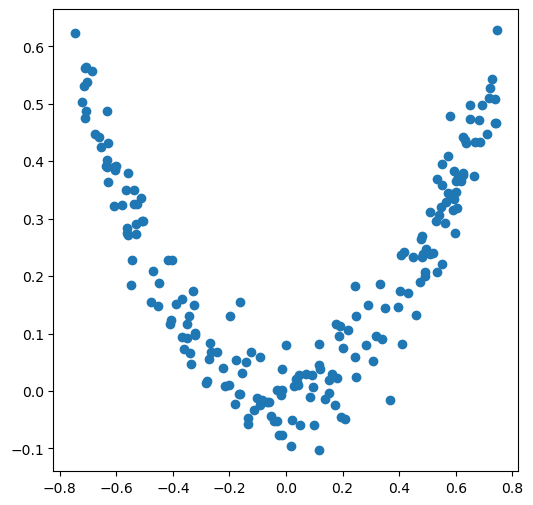

In [32]:
#Make some polynomial data:
#####

N = 200
#Random x data
X = np.random.uniform(-.75,.75,N)
X.sort()

y = X**2 + np.random.normal(loc=0, scale=.05, size=N)
X = X.reshape(-1,1)

fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(X,y)

In [34]:
from sklearn.tree import DecisionTreeRegressor

#Fit our initial tree:
#####

tree1 = DecisionTreeRegressor(max_depth=2, random_state=42)

tree1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Tree1 Residuals')

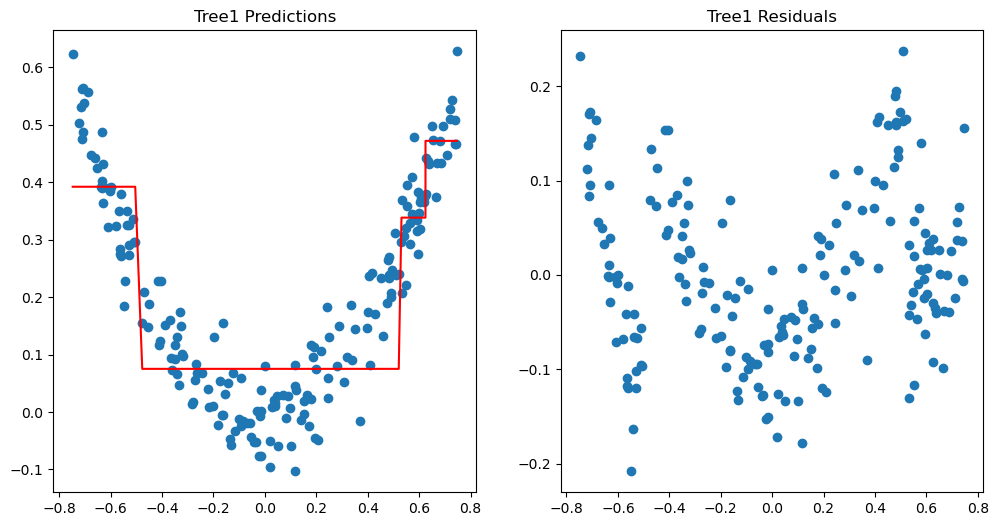

In [35]:
## Now, get the residuals:
y2 = y - tree1.predict(X)

#Plot:
fig, ax1 = plt.subplots(1,2, figsize=(12, 6))
ax1[0].scatter(X,y)
ax1[0].plot(X, tree1.predict(X), color='red')
ax1[0].set_title('Tree1 Predictions')

ax1[1].scatter(X, y2)
ax1[1].set_title('Tree1 Residuals')

In [37]:
## Train our second tree:
#####
tree2 = DecisionTreeRegressor(max_depth=2, random_state=42)

tree2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Tree2 Residuals')

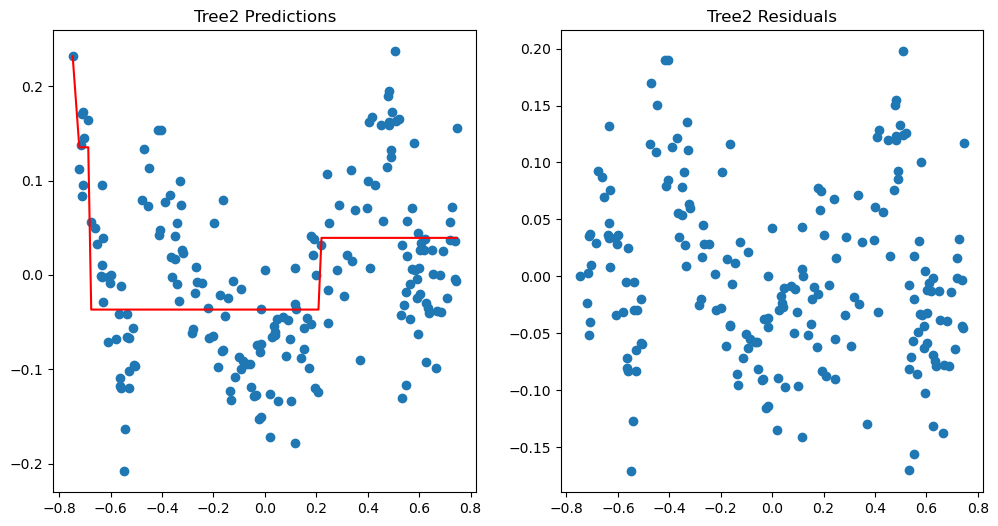

In [38]:
## Now, get the residuals:
y3 = y2 - tree2.predict(X)

#Plot:
fig, ax1 = plt.subplots(1,2, figsize=(12, 6))
ax1[0].scatter(X,y2)
ax1[0].plot(X, tree2.predict(X), color='red')
ax1[0].set_title('Tree2 Predictions')

ax1[1].scatter(X, y3)
ax1[1].set_title('Tree2 Residuals')

In [40]:
## Train our third tree:
#####
tree3 = DecisionTreeRegressor(max_depth=2, random_state=42)

tree3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Tree3 Residuals')

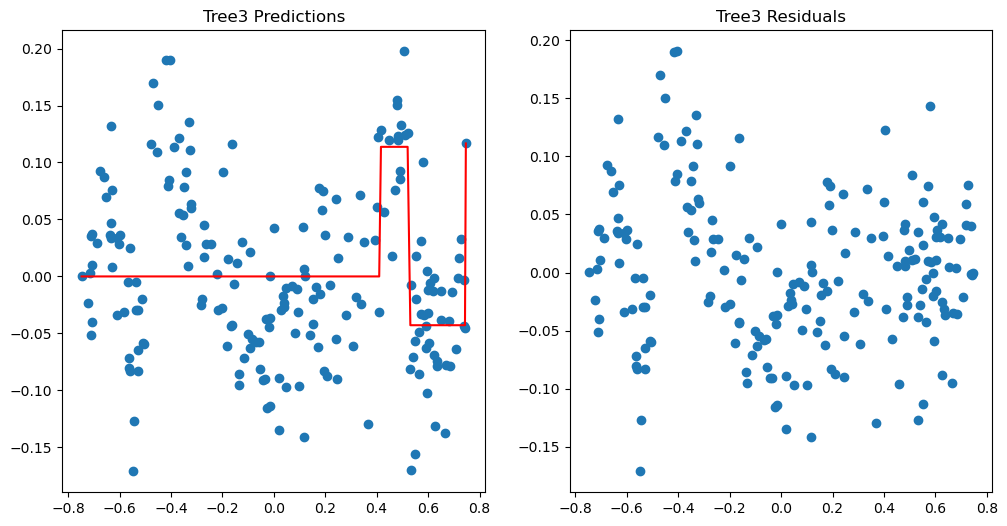

In [41]:
## More residuals, more plot
y4 = y3 - tree3.predict(X)

#Plot:
fig, ax1 = plt.subplots(1,2, figsize=(12, 6))
ax1[0].scatter(X,y3)
ax1[0].plot(X, tree3.predict(X), color='red')
ax1[0].set_title('Tree3 Predictions')

ax1[1].scatter(X, y4)
ax1[1].set_title('Tree3 Residuals')

### Sum up the ensemble predictions:

In [43]:
## Sum up predictions for each tree:
######

final_pred = sum(tree.predict(X) for tree in (tree1, tree2, tree3))

#Compare to
#final_pred = tree1.predict(X)
#final_pred = sum(tree.predict(X) for tree in (tree1, tree2))

Text(0.5, 1.0, 'Ensemble Predictions')

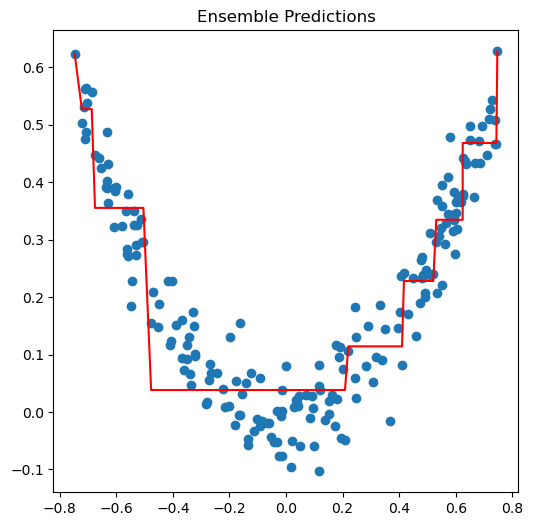

In [44]:
#Plot:
fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(X,y)
ax1.plot(X, final_pred, color='red')
ax1.set_title('Ensemble Predictions')



### Scikit-Learn GradientBoostingRegressor

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1,
                                 random_state=42)

gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

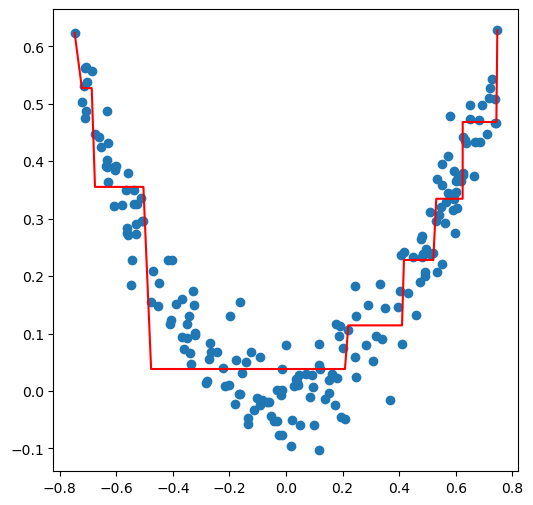

In [51]:
#Plot:
fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(X,y)
ax1.plot(X, gbrt.predict(X), color='red')

In [62]:
## Another!

#Try different learning rates
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=500,
                                 learning_rate=.1,
                                 n_iter_no_change=10,
                                 random_state=42)

gbrt.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=500, n_iter_no_change=10,
                          random_state=42)

In [63]:
gbrt.n_estimators_

33

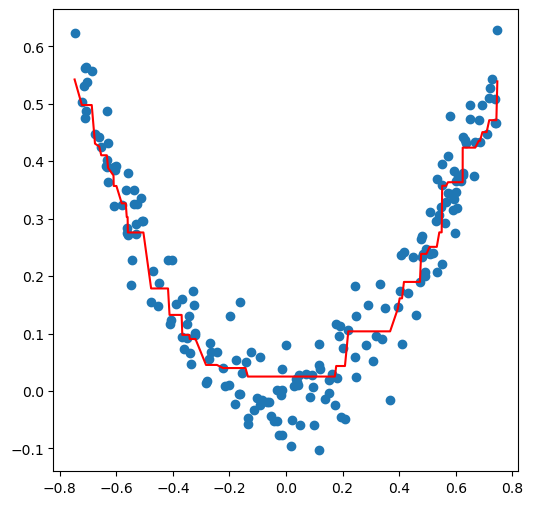

In [64]:
#Plot:
fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
ax1.scatter(X,y)
ax1.plot(X, gbrt.predict(X), color='red')